#In this problem, first, we want to implement a baseline neural network classification model, and then improve it.
write your code in the provided area.

# Importing required packages

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.utils.data import Subset
import random

# Load and preprocess the Fashion MNIST dataset from torchvision package

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

train_data = datasets.FashionMNIST(root = "C:\\Users\\ASUS", download = False, train = True, transform = transform)
test_data = datasets.FashionMNIST(root = "C:\\Users\\ASUS", download = False, train = False, transform = transform)

# Split dataset into train, validation, and test sets(80 percent for training dataset)

In [7]:
train_size = int(0.8*len(train_data))
val_size = len(train_data)-int(0.8*len(train_data))
train_data, val_data = random_split(train_data, [train_size, val_size])

# Create Data loaders for training, validation, and test sets.

In [9]:
train_dataloader = DataLoader(train_data, batch_size=64)
train_dataloader.shuffle = True

val_dataloader = DataLoader(val_data, batch_size=64)
val_dataloader.shuffle = False

test_dataloader = DataLoader(test_data, batch_size=64)
test_dataloader.shuffle = False


# Visualize some samples from each each class

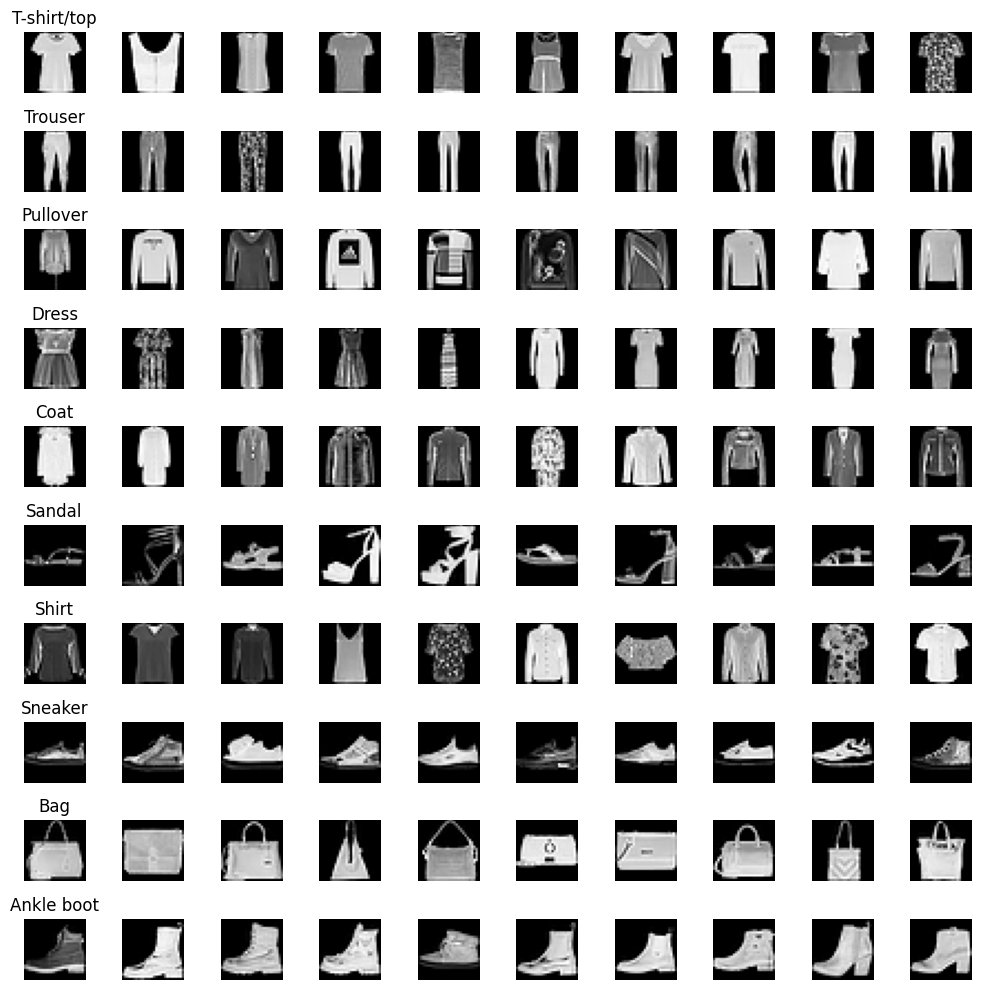

In [11]:
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]
plt.figure(figsize=(10, 10))
c = 0
for i in range(10):
    indices = [j for j, (_, label) in enumerate(train_data) if label == i]
    selected_indices = torch.randperm(len(indices))[:10]
    for j, idx in enumerate(selected_indices):
        plt.subplot(10, 10, c + 1)
        plt.imshow(train_data[indices[idx]][0].squeeze(), cmap='gray')
        plt.axis('off')
        if j == 0:
            plt.title(class_names[i])
        c += 1
plt.tight_layout()
plt.show()


# Define a simple neural network (MLP) without convolution layers

In [13]:
class ReLUModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)


In [14]:
class TanhModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)


# Define your loss function, and optimizer

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
relu_model = ReLUModel().to(device)
tanh_model = TanhModel().to(device)
criterion = nn.CrossEntropyLoss()
relu_optimizer = optim.Adam(relu_model.parameters(), lr = 0.001)
tanh_optimizer = optim.Adam(tanh_model.parameters(), lr = 0.001)

#Train two models: one using the ReLU activation function and the other using the Tanh activation function, while keeping all other parameters the same. Finally, report the accuracies on the test dataset.

#In one figure, plot the loss over epochs for both the training and validation sets. In a separate figure, plot the accuracy over epochs for the training and validation sets for both models.(At the end, you should have 4 figures)

#How do the models differ in terms of performance?

In [18]:
num_epochs = 30

train_losses = {'relu': [], 'tanh': []}
train_accs = {'relu': [], 'tanh': []}
val_losses = {'relu': [], 'tanh': []}
val_accs = {'relu': [], 'tanh': []}

for epoch in range(num_epochs):

    epoch_train_losses = {'relu': 0, 'tanh': 0}
    epoch_train_accs = {'relu': 0, 'tanh': 0}

    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)

        relu_optimizer.zero_grad()
        tanh_optimizer.zero_grad()

        relu_outputs = relu_model(images)
        tanh_outputs = tanh_model(images)

        relu_loss = criterion(relu_outputs, labels)
        tanh_loss = criterion(tanh_outputs, labels)

        relu_loss.backward()
        tanh_loss.backward()

        relu_optimizer.step()
        tanh_optimizer.step()

        epoch_train_losses['relu'] += relu_loss.item()
        epoch_train_losses['tanh'] += tanh_loss.item()

        epoch_train_accs['relu'] += (torch.argmax(relu_outputs, dim=1) == labels).sum().item()
        epoch_train_accs['tanh'] += (torch.argmax(tanh_outputs, dim=1) == labels).sum().item()

    train_losses['relu'].append(epoch_train_losses['relu'] / len(train_data))
    train_losses['tanh'].append(epoch_train_losses['tanh'] / len(train_data))

    train_accs['relu'].append(epoch_train_accs['relu'] / len(train_data) * 100)
    train_accs['tanh'].append(epoch_train_accs['tanh'] / len(train_data) * 100)

    print(f"Epoch {epoch + 1}:")
    print(f"ReLU - Train Loss: {train_losses['relu'][-1]}, Train Accuracy: {train_accs['relu'][-1]}%")
    print(f"Tanh - Train Loss: {train_losses['tanh'][-1]}, Train Accuracy: {train_accs['tanh'][-1]}%")

    with torch.no_grad():
        epoch_val_losses = {'relu': 0, 'tanh': 0}
        epoch_val_accs = {'relu': 0, 'tanh': 0}

        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)

            relu_outputs = relu_model(images)
            tanh_outputs = tanh_model(images)

            relu_loss = criterion(relu_outputs, labels)
            tanh_loss = criterion(tanh_outputs, labels)

            epoch_val_losses['relu'] += relu_loss.item()
            epoch_val_losses['tanh'] += tanh_loss.item()

            epoch_val_accs['relu'] += (torch.argmax(relu_outputs, dim=1) == labels).sum().item()
            epoch_val_accs['tanh'] += (torch.argmax(tanh_outputs, dim=1) == labels).sum().item()

        val_losses['relu'].append(epoch_val_losses['relu'] / len(val_data))
        val_losses['tanh'].append(epoch_val_losses['tanh'] / len(val_data))

        val_accs['relu'].append(epoch_val_accs['relu'] / len(val_data) * 100)
        val_accs['tanh'].append(epoch_val_accs['tanh'] / len(val_data) * 100)

        print(f"ReLU - Validation Loss: {val_losses['relu'][-1]}, Validation Accuracy: {val_accs['relu'][-1]}%")
        print(f"Tanh - Validation Loss: {val_losses['tanh'][-1]}, Validation Accuracy: {val_accs['tanh'][-1]}%")


Epoch 1/30: 100%|██████████| 750/750 [00:09<00:00, 81.89it/s]


Epoch 1:
ReLU - Train Loss: 0.027589578710496426, Train Accuracy: 69.62708333333333%
Tanh - Train Loss: 0.027129790276288986, Train Accuracy: 73.73125%
ReLU - Validation Loss: 0.027038962552944818, Validation Accuracy: 73.36666666666667%
Tanh - Validation Loss: 0.02683518733580907, Validation Accuracy: 74.84166666666667%


Epoch 2/30: 100%|██████████| 750/750 [00:12<00:00, 60.28it/s]


Epoch 2:
ReLU - Train Loss: 0.026944276529053846, Train Accuracy: 73.59791666666666%
Tanh - Train Loss: 0.026298592848082385, Train Accuracy: 77.8125%
ReLU - Validation Loss: 0.026868041117986043, Validation Accuracy: 74.575%
Tanh - Validation Loss: 0.026448221315940223, Validation Accuracy: 77.44166666666666%


Epoch 3/30: 100%|██████████| 750/750 [00:12<00:00, 60.11it/s]


Epoch 3:
ReLU - Train Loss: 0.026363692519565423, Train Accuracy: 77.31041666666667%
Tanh - Train Loss: 0.025905495213965575, Train Accuracy: 80.27916666666667%
ReLU - Validation Loss: 0.02606887196501096, Validation Accuracy: 79.63333333333334%
Tanh - Validation Loss: 0.02668494721253713, Validation Accuracy: 75.875%


Epoch 4/30: 100%|██████████| 750/750 [00:12<00:00, 60.21it/s]


Epoch 4:
ReLU - Train Loss: 0.02609454584121704, Train Accuracy: 79.07916666666667%
Tanh - Train Loss: 0.02567767106741667, Train Accuracy: 81.77916666666667%
ReLU - Validation Loss: 0.02600701895356178, Validation Accuracy: 80.10000000000001%
Tanh - Validation Loss: 0.02560970722635587, Validation Accuracy: 82.65833333333333%


Epoch 5/30: 100%|██████████| 750/750 [00:12<00:00, 60.48it/s]


Epoch 5:
ReLU - Train Loss: 0.026086238361895085, Train Accuracy: 79.12291666666667%
Tanh - Train Loss: 0.025609945692121983, Train Accuracy: 82.21875%
ReLU - Validation Loss: 0.0260420839091142, Validation Accuracy: 79.86666666666666%
Tanh - Validation Loss: 0.026090220550696056, Validation Accuracy: 79.55%


Epoch 6/30: 100%|██████████| 750/750 [00:12<00:00, 60.27it/s]


Epoch 6:
ReLU - Train Loss: 0.025989670072992643, Train Accuracy: 79.75833333333333%
Tanh - Train Loss: 0.02556252903242906, Train Accuracy: 82.52708333333332%
ReLU - Validation Loss: 0.025988394836584727, Validation Accuracy: 80.21666666666667%
Tanh - Validation Loss: 0.02568143297235171, Validation Accuracy: 82.15833333333333%


Epoch 7/30: 100%|██████████| 750/750 [00:12<00:00, 60.41it/s]


Epoch 7:
ReLU - Train Loss: 0.026013936241467795, Train Accuracy: 79.58958333333334%
Tanh - Train Loss: 0.02548472405721744, Train Accuracy: 83.00416666666666%
ReLU - Validation Loss: 0.026603392908970513, Validation Accuracy: 76.275%
Tanh - Validation Loss: 0.02565379670262337, Validation Accuracy: 82.29166666666666%


Epoch 8/30: 100%|██████████| 750/750 [00:12<00:00, 60.34it/s]


Epoch 8:
ReLU - Train Loss: 0.025999649435281755, Train Accuracy: 79.69375%
Tanh - Train Loss: 0.02549253396689892, Train Accuracy: 82.96666666666667%
ReLU - Validation Loss: 0.026267003069321313, Validation Accuracy: 78.425%
Tanh - Validation Loss: 0.02574034901460012, Validation Accuracy: 81.8%


Epoch 9/30: 100%|██████████| 750/750 [00:12<00:00, 60.14it/s]


Epoch 9:
ReLU - Train Loss: 0.026043514537314575, Train Accuracy: 79.4125%
Tanh - Train Loss: 0.025437677554786205, Train Accuracy: 83.3%
ReLU - Validation Loss: 0.026461446324984234, Validation Accuracy: 77.18333333333334%
Tanh - Validation Loss: 0.025680336008469265, Validation Accuracy: 82.28333333333333%


Epoch 10/30: 100%|██████████| 750/750 [00:12<00:00, 60.17it/s]


Epoch 10:
ReLU - Train Loss: 0.025909702174365522, Train Accuracy: 80.28125%
Tanh - Train Loss: 0.025406680998702844, Train Accuracy: 83.46875%
ReLU - Validation Loss: 0.025850133299827577, Validation Accuracy: 81.08333333333333%
Tanh - Validation Loss: 0.025635782132546105, Validation Accuracy: 82.5%


Epoch 11/30: 100%|██████████| 750/750 [00:12<00:00, 60.31it/s]


Epoch 11:
ReLU - Train Loss: 0.026221192933619023, Train Accuracy: 78.28125%
Tanh - Train Loss: 0.02539828479786714, Train Accuracy: 83.54166666666667%
ReLU - Validation Loss: 0.026013518800338108, Validation Accuracy: 80.075%
Tanh - Validation Loss: 0.02573732031385104, Validation Accuracy: 81.74166666666667%


Epoch 12/30: 100%|██████████| 750/750 [00:12<00:00, 60.07it/s]


Epoch 12:
ReLU - Train Loss: 0.025983141536513963, Train Accuracy: 79.81041666666667%
Tanh - Train Loss: 0.02535138757030169, Train Accuracy: 83.86666666666667%
ReLU - Validation Loss: 0.026538626730442046, Validation Accuracy: 76.68333333333334%
Tanh - Validation Loss: 0.02555454604824384, Validation Accuracy: 83.08333333333333%


Epoch 13/30: 100%|██████████| 750/750 [00:12<00:00, 59.71it/s]


Epoch 13:
ReLU - Train Loss: 0.026118179137508076, Train Accuracy: 78.94166666666666%
Tanh - Train Loss: 0.025335283088187378, Train Accuracy: 83.94791666666667%
ReLU - Validation Loss: 0.02624289490779241, Validation Accuracy: 78.57499999999999%
Tanh - Validation Loss: 0.025371851285298664, Validation Accuracy: 84.18333333333334%


Epoch 14/30: 100%|██████████| 750/750 [00:13<00:00, 56.97it/s]


Epoch 14:
ReLU - Train Loss: 0.025975021523733932, Train Accuracy: 79.85833333333333%
Tanh - Train Loss: 0.02532215472559134, Train Accuracy: 84.08333333333333%
ReLU - Validation Loss: 0.026737320691347124, Validation Accuracy: 75.43333333333334%
Tanh - Validation Loss: 0.02545255438486735, Validation Accuracy: 83.6%


Epoch 15/30: 100%|██████████| 750/750 [00:12<00:00, 58.36it/s]


Epoch 15:
ReLU - Train Loss: 0.026198097966611385, Train Accuracy: 78.43958333333333%
Tanh - Train Loss: 0.025311527751386165, Train Accuracy: 84.13333333333334%
ReLU - Validation Loss: 0.026046733697255454, Validation Accuracy: 79.85833333333333%
Tanh - Validation Loss: 0.02570111475388209, Validation Accuracy: 82.10833333333333%


Epoch 16/30: 100%|██████████| 750/750 [00:13<00:00, 56.76it/s]


Epoch 16:
ReLU - Train Loss: 0.0260671311840415, Train Accuracy: 79.27499999999999%
Tanh - Train Loss: 0.02524681563427051, Train Accuracy: 84.50416666666666%
ReLU - Validation Loss: 0.02639773174126943, Validation Accuracy: 77.59166666666667%
Tanh - Validation Loss: 0.025447703490654627, Validation Accuracy: 83.6%


Epoch 17/30: 100%|██████████| 750/750 [00:13<00:00, 57.09it/s]


Epoch 17:
ReLU - Train Loss: 0.02599850255747636, Train Accuracy: 79.71666666666667%
Tanh - Train Loss: 0.0252845410729448, Train Accuracy: 84.28750000000001%
ReLU - Validation Loss: 0.027015697052081428, Validation Accuracy: 73.68333333333334%
Tanh - Validation Loss: 0.025477810621261598, Validation Accuracy: 83.46666666666667%


Epoch 18/30: 100%|██████████| 750/750 [00:12<00:00, 60.27it/s]


Epoch 18:
ReLU - Train Loss: 0.02630926651507616, Train Accuracy: 77.72916666666667%
Tanh - Train Loss: 0.025216587610542775, Train Accuracy: 84.67083333333333%
ReLU - Validation Loss: 0.02612907048066457, Validation Accuracy: 79.33333333333333%
Tanh - Validation Loss: 0.025434246877829234, Validation Accuracy: 83.81666666666666%


Epoch 19/30: 100%|██████████| 750/750 [00:12<00:00, 61.48it/s]


Epoch 19:
ReLU - Train Loss: 0.026117473016182582, Train Accuracy: 78.96041666666666%
Tanh - Train Loss: 0.025233572425941625, Train Accuracy: 84.6%
ReLU - Validation Loss: 0.026281591991583506, Validation Accuracy: 78.35%
Tanh - Validation Loss: 0.025401312718788784, Validation Accuracy: 83.95%


Epoch 20/30: 100%|██████████| 750/750 [00:12<00:00, 60.85it/s]


Epoch 20:
ReLU - Train Loss: 0.026331092779835065, Train Accuracy: 77.58958333333334%
Tanh - Train Loss: 0.025208663801352182, Train Accuracy: 84.76458333333333%
ReLU - Validation Loss: 0.026752884676059088, Validation Accuracy: 75.325%
Tanh - Validation Loss: 0.025443585932254792, Validation Accuracy: 83.65%


Epoch 21/30: 100%|██████████| 750/750 [00:12<00:00, 59.60it/s]


Epoch 21:
ReLU - Train Loss: 0.026498574351270992, Train Accuracy: 76.52083333333334%
Tanh - Train Loss: 0.025224479407072068, Train Accuracy: 84.61666666666666%
ReLU - Validation Loss: 0.026429454227288564, Validation Accuracy: 77.38333333333334%
Tanh - Validation Loss: 0.02539873660604159, Validation Accuracy: 83.93333333333334%


Epoch 22/30: 100%|██████████| 750/750 [00:12<00:00, 61.41it/s]


Epoch 22:
ReLU - Train Loss: 0.026271493223806223, Train Accuracy: 77.97291666666666%
Tanh - Train Loss: 0.025221012249588965, Train Accuracy: 84.69791666666666%
ReLU - Validation Loss: 0.026737968871990838, Validation Accuracy: 75.41666666666667%
Tanh - Validation Loss: 0.02548422735929489, Validation Accuracy: 83.39999999999999%


Epoch 23/30: 100%|██████████| 750/750 [00:12<00:00, 61.76it/s]


Epoch 23:
ReLU - Train Loss: 0.026693932823836804, Train Accuracy: 75.28125%
Tanh - Train Loss: 0.02518066593259573, Train Accuracy: 84.98333333333333%
ReLU - Validation Loss: 0.029353991558154425, Validation Accuracy: 58.71666666666666%
Tanh - Validation Loss: 0.025608605911334355, Validation Accuracy: 82.65%


Epoch 24/30: 100%|██████████| 750/750 [00:12<00:00, 62.04it/s]


Epoch 24:
ReLU - Train Loss: 0.026826156246165436, Train Accuracy: 74.42708333333333%
Tanh - Train Loss: 0.025157366330424945, Train Accuracy: 85.12708333333333%
ReLU - Validation Loss: 0.02629878172278404, Validation Accuracy: 78.23333333333333%
Tanh - Validation Loss: 0.025494849036137263, Validation Accuracy: 83.36666666666666%


Epoch 25/30: 100%|██████████| 750/750 [00:12<00:00, 61.13it/s]


Epoch 25:
ReLU - Train Loss: 0.02697582067300876, Train Accuracy: 73.46875%
Tanh - Train Loss: 0.025262378036975862, Train Accuracy: 84.40208333333334%
ReLU - Validation Loss: 0.026499159832795462, Validation Accuracy: 76.95%
Tanh - Validation Loss: 0.025407334198554357, Validation Accuracy: 83.93333333333334%


Epoch 26/30: 100%|██████████| 750/750 [00:12<00:00, 61.02it/s]


Epoch 26:
ReLU - Train Loss: 0.026342735027273495, Train Accuracy: 77.51875%
Tanh - Train Loss: 0.025234772379199664, Train Accuracy: 84.61458333333334%
ReLU - Validation Loss: 0.026704620083173116, Validation Accuracy: 75.66666666666667%
Tanh - Validation Loss: 0.025419984738032024, Validation Accuracy: 83.86666666666667%


Epoch 27/30: 100%|██████████| 750/750 [00:12<00:00, 58.98it/s]


Epoch 27:
ReLU - Train Loss: 0.026549320466816427, Train Accuracy: 76.19583333333333%
Tanh - Train Loss: 0.02522459188103676, Train Accuracy: 84.68958333333333%
ReLU - Validation Loss: 0.026319822172323863, Validation Accuracy: 78.09166666666667%
Tanh - Validation Loss: 0.025323695719242097, Validation Accuracy: 84.45833333333333%


Epoch 28/30: 100%|██████████| 750/750 [00:12<00:00, 61.55it/s]


Epoch 28:
ReLU - Train Loss: 0.026556269489228724, Train Accuracy: 76.15416666666667%
Tanh - Train Loss: 0.0252141279305021, Train Accuracy: 84.71875%
ReLU - Validation Loss: 0.028512986421585083, Validation Accuracy: 64.125%
Tanh - Validation Loss: 0.025592635015646615, Validation Accuracy: 82.65833333333333%


Epoch 29/30: 100%|██████████| 750/750 [00:12<00:00, 61.86it/s]


Epoch 29:
ReLU - Train Loss: 0.027376631505787372, Train Accuracy: 70.89791666666667%
Tanh - Train Loss: 0.02523574919005235, Train Accuracy: 84.59583333333333%
ReLU - Validation Loss: 0.028557869603236516, Validation Accuracy: 63.84166666666666%
Tanh - Validation Loss: 0.025449123561382295, Validation Accuracy: 83.51666666666667%


Epoch 30/30: 100%|██████████| 750/750 [00:12<00:00, 60.21it/s]


Epoch 30:
ReLU - Train Loss: 0.027799770476917427, Train Accuracy: 68.18958333333333%
Tanh - Train Loss: 0.025187590102354687, Train Accuracy: 84.87916666666668%
ReLU - Validation Loss: 0.02949876262744268, Validation Accuracy: 57.833333333333336%
Tanh - Validation Loss: 0.025416502902905147, Validation Accuracy: 83.83333333333334%


In [19]:
test_losses = {'relu': 0, 'tanh': 0}
test_accs = {'relu': 0, 'tanh': 0}

with torch.no_grad():

    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        relu_outputs = relu_model(images)
        tanh_outputs = tanh_model(images)

        relu_loss = criterion(relu_outputs, labels)
        tanh_loss = criterion(tanh_outputs, labels)

        test_losses['relu'] += relu_loss.item()
        test_losses['tanh'] += tanh_loss.item()

        test_accs['relu'] += (torch.argmax(relu_outputs, dim=1) == labels).sum().item()
        test_accs['tanh'] += (torch.argmax(tanh_outputs, dim=1) == labels).sum().item()

    print(f"ReLU - Test Loss: {test_losses['relu'] / len(test_data)}, Test Accuracy: {test_accs['relu'] / len(test_data) * 100}%")
    print(f"Tanh - Test Loss: {test_losses['tanh'] / len(test_data)}, Test Accuracy: {test_accs['tanh'] / len(test_data) * 100}%")


ReLU - Test Loss: 0.02961110174655914, Test Accuracy: 57.38999999999999%
Tanh - Test Loss: 0.02550846438407898, Test Accuracy: 83.54%


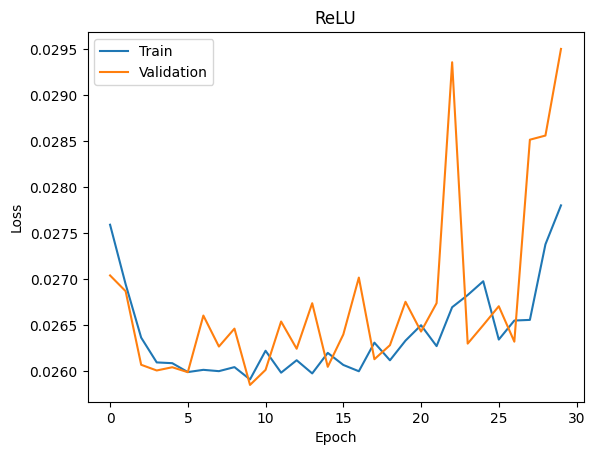

In [20]:
plt.plot(range(num_epochs), train_losses['relu'], label="Train")
plt.plot(range(num_epochs), val_losses['relu'], label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ReLU")

plt.legend()


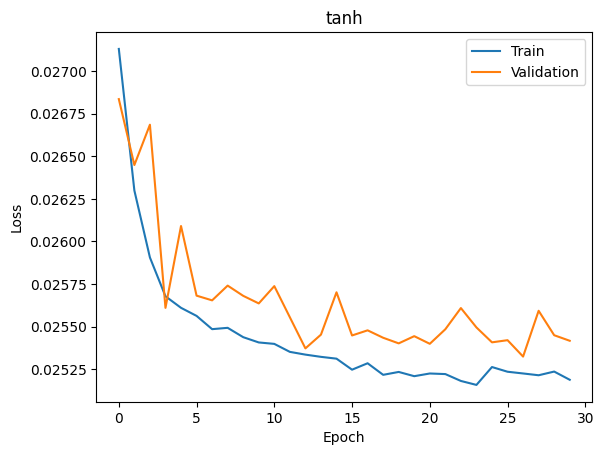

In [21]:
plt.plot(range(num_epochs), train_losses['tanh'], label="Train")
plt.plot(range(num_epochs), val_losses['tanh'], label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("tanh")

plt.legend()

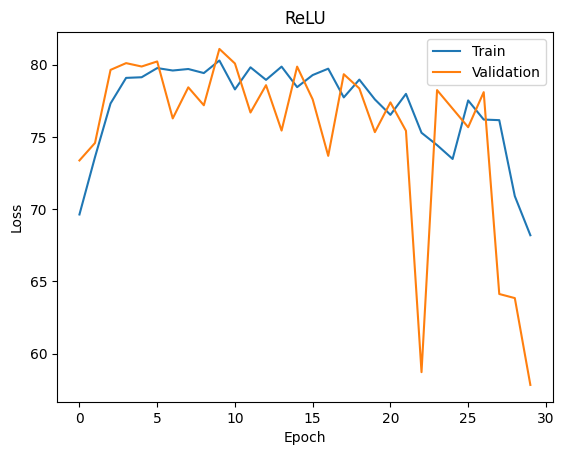

In [22]:
plt.plot(range(num_epochs), train_accs['relu'], label="Train")
plt.plot(range(num_epochs), val_accs['relu'], label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ReLU")

plt.legend()

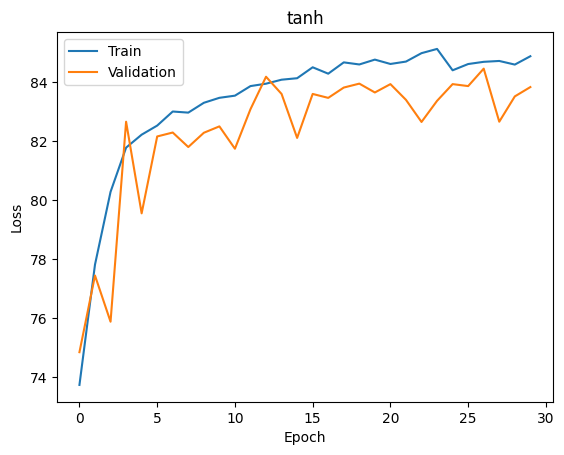

In [23]:
plt.plot(range(num_epochs), train_accs['tanh'], label="Train")
plt.plot(range(num_epochs), val_accs['tanh'], label="Validation")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("tanh")

plt.legend()

#What was the optimum number of epochs for training? why?

#Repeat all the previous sections, but this time, add some convolutional layers to your model.

In [26]:
class CNNReLUModel(nn.Module):

    def __init__(self):
        super(CNNReLUModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, 3)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv2d(128, 64, 3)
        self.relu3 = nn.ReLU()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(22 * 22 * 64, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu5 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)
        self.relu6 = nn.ReLU()
        self.fc4 = nn.Linear(128, 64)
        self.relu7 = nn.ReLU()
        self.fc5 = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.fc3(x)
        x = self.relu6(x)
        x = self.fc4(x)
        x = self.relu7(x)
        x = self.fc5(x)
        x = self.softmax(x)

        return x


In [27]:
class CNNTanhModel(nn.Module):

    def __init__(self):
        super(CNNTanhModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 64, kernel_size = 3)
        self.tanh1 = nn.Tanh()
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3)
        self.tanh2 = nn.Tanh()
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size = 3)
        self.tanh3 = nn.Tanh()

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(22 * 22 * 64, 512)
        self.tanh4 = nn.Tanh()
        self.fc2 = nn.Linear(512, 256)
        self.tanh5 = nn.Tanh()
        self.fc3 = nn.Linear(256, 128)
        self.tanh6 = nn.Tanh()
        self.fc4 = nn.Linear(128, 64)
        self.tanh7 = nn.Tanh()
        self.fc5 = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        x = self.conv1(x)
        x = self.tanh1(x)
        x = self.conv2(x)
        x = self.tanh2(x)
        x = self.conv3(x)
        x = self.tanh3(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.tanh4(x)
        x = self.fc2(x)
        x = self.tanh5(x)
        x = self.fc3(x)
        x = self.tanh6(x)
        x = self.fc4(x)
        x = self.tanh7(x)
        x = self.fc5(x)
        x = self.softmax(x)

        return x

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_relu_model = CNNReLUModel().to(device)
cnn_tanh_model = CNNTanhModel().to(device)
cnn_relu_optimizer = optim.Adam(cnn_relu_model.parameters(), lr = 0.001)
cnn_tanh_optimizer = optim.Adam(cnn_tanh_model.parameters(), lr = 0.001)

In [29]:
num_epochs = 30

cnn_relu_train_losses, cnn_relu_train_accs = [], []
cnn_tanh_train_losses, cnn_tanh_train_accs = [], []
cnn_relu_val_losses, cnn_relu_val_accs = [], []
cnn_tanh_val_losses, cnn_tanh_val_accs = [], []


for epoch in range(num_epochs):
    cnn_relu_train_loss, cnn_relu_train_acc = 0, 0
    cnn_tanh_train_loss, cnn_tanh_train_acc = 0, 0

    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        cnn_relu_optimizer.zero_grad()
        cnn_tanh_optimizer.zero_grad()

        cnn_relu_outputs = cnn_relu_model.forward(images)
        cnn_tanh_outputs = cnn_tanh_model.forward(images)

        cnn_relu_loss = criterion(cnn_relu_outputs, labels)
        cnn_tanh_loss = criterion(cnn_tanh_outputs, labels)

        cnn_relu_loss.backward()
        cnn_tanh_loss.backward()

        cnn_relu_optimizer.step()
        cnn_tanh_optimizer.step()

        cnn_relu_train_loss += cnn_relu_loss
        cnn_tanh_train_loss += cnn_tanh_loss

        cnn_relu_train_acc += (torch.argmax(cnn_relu_outputs, dim=1) == labels).sum()
        cnn_tanh_train_acc += (torch.argmax(cnn_tanh_outputs, dim=1) == labels).sum()

    cnn_relu_train_losses.append(cnn_relu_train_loss.item() / len(train_data))
    cnn_tanh_train_losses.append(cnn_tanh_train_loss.item() / len(train_data))
    cnn_relu_train_accs.append(cnn_relu_train_acc.item() / len(train_data) * 100)
    cnn_tanh_train_accs.append(cnn_tanh_train_acc.item() / len(train_data) * 100)

    print(f"epoch = {epoch + 1}")
    print(f"cnn_relu_train_loss = {cnn_relu_train_losses[-1]} cnn_relu_train_acc = {cnn_relu_train_accs[-1]}")
    print(f"cnn_tanh_train_loss = {cnn_tanh_train_losses[-1]} cnn_tanh_train_acc = {cnn_tanh_train_accs[-1]}")

    with torch.no_grad():
        cnn_relu_val_loss, cnn_tanh_val_loss = 0, 0
        cnn_relu_val_acc, cnn_tanh_val_acc = 0, 0

        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)

            cnn_relu_outputs = cnn_relu_model.forward(images)
            cnn_tanh_outputs = cnn_tanh_model.forward(images)

            cnn_relu_loss = criterion(cnn_relu_outputs, labels)
            cnn_tanh_loss = criterion(cnn_tanh_outputs, labels)

            cnn_relu_val_loss += cnn_relu_loss
            cnn_tanh_val_loss += cnn_tanh_loss

            cnn_relu_val_acc += (torch.argmax(cnn_relu_outputs, dim=1) == labels).sum()
            cnn_tanh_val_acc += (torch.argmax(cnn_tanh_outputs, dim=1) == labels).sum()

        print(f"cnn_relu_val_loss = {cnn_relu_val_loss.item() / len(val_data)} cnn_relu_val_acc = {cnn_relu_val_acc.item() / len(val_data) * 100}")
        print(f"cnn_tanh_val_loss = {cnn_tanh_val_loss.item() / len(val_data)} cnn_tanh_val_acc = {cnn_tanh_val_acc.item() / len(val_data) * 100}")

        cnn_relu_val_losses.append(cnn_relu_val_loss.item() / len(val_data))
        cnn_tanh_val_losses.append(cnn_tanh_val_loss.item() / len(val_data))

        cnn_relu_val_accs.append(cnn_relu_val_acc.item() / len(val_data) * 100)
        cnn_tanh_val_accs.append(cnn_tanh_val_acc.item() / len(val_data) * 100)


Epoch 1/30: 100%|██████████| 750/750 [00:25<00:00, 29.00it/s]


epoch = 1
cnn_relu_train_loss = 0.03247747802734375 cnn_relu_train_acc = 38.21041666666667
cnn_tanh_train_loss = 0.02752014414469401 cnn_tanh_train_acc = 71.48958333333333
cnn_relu_val_loss = 0.0325083491007487 cnn_relu_val_acc = 38.61666666666667
cnn_tanh_val_loss = 0.027052167256673178 cnn_tanh_val_acc = 73.55000000000001


Epoch 2/30: 100%|██████████| 750/750 [00:26<00:00, 27.99it/s]


epoch = 2
cnn_relu_train_loss = 0.03474517567952474 cnn_relu_train_acc = 23.745833333333334
cnn_tanh_train_loss = 0.026917752583821616 cnn_tanh_train_acc = 73.93333333333332
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.026642092386881512 cnn_tanh_val_acc = 76.23333333333333


Epoch 3/30: 100%|██████████| 750/750 [00:28<00:00, 26.58it/s]


epoch = 3
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.026809422810872396 cnn_tanh_train_acc = 74.58958333333334
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.026683639526367188 cnn_tanh_val_acc = 76.01666666666667


Epoch 4/30: 100%|██████████| 750/750 [00:28<00:00, 26.13it/s]


epoch = 4
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.0266004638671875 cnn_tanh_train_acc = 75.89791666666666
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.0269158935546875 cnn_tanh_val_acc = 74.45833333333334


Epoch 5/30: 100%|██████████| 750/750 [00:28<00:00, 25.97it/s]


epoch = 5
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.026713284810384114 cnn_tanh_train_acc = 75.14375
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.026531097412109374 cnn_tanh_val_acc = 76.725


Epoch 6/30: 100%|██████████| 750/750 [00:28<00:00, 25.98it/s]


epoch = 6
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.02648003133138021 cnn_tanh_train_acc = 76.63125
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.02619243367513021 cnn_tanh_val_acc = 78.79166666666667


Epoch 7/30: 100%|██████████| 750/750 [00:28<00:00, 26.12it/s]


epoch = 7
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.026410741170247398 cnn_tanh_train_acc = 77.02708333333334
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.02668659464518229 cnn_tanh_val_acc = 75.825


Epoch 8/30: 100%|██████████| 750/750 [00:28<00:00, 26.15it/s]


epoch = 8
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.026415384928385417 cnn_tanh_train_acc = 77.0
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.026616218566894532 cnn_tanh_val_acc = 76.19166666666666


Epoch 9/30: 100%|██████████| 750/750 [00:28<00:00, 26.13it/s]


epoch = 9
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.02627423604329427 cnn_tanh_train_acc = 77.93958333333333
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.02653626251220703 cnn_tanh_val_acc = 76.71666666666667


Epoch 10/30: 100%|██████████| 750/750 [00:28<00:00, 26.13it/s]


epoch = 10
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.02638990275065104 cnn_tanh_train_acc = 77.18333333333334
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.026439107259114584 cnn_tanh_val_acc = 77.17500000000001


Epoch 11/30: 100%|██████████| 750/750 [00:28<00:00, 26.08it/s]


epoch = 11
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.026333635965983072 cnn_tanh_train_acc = 77.48958333333333
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.02626361083984375 cnn_tanh_val_acc = 78.41666666666667


Epoch 12/30: 100%|██████████| 750/750 [00:28<00:00, 25.95it/s]


epoch = 12
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.026147196451822917 cnn_tanh_train_acc = 78.73333333333333
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.02635492451985677 cnn_tanh_val_acc = 77.90833333333333


Epoch 13/30: 100%|██████████| 750/750 [00:28<00:00, 26.08it/s]


epoch = 13
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.026228294372558594 cnn_tanh_train_acc = 78.20208333333333
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.026445869445800782 cnn_tanh_val_acc = 77.275


Epoch 14/30: 100%|██████████| 750/750 [00:28<00:00, 26.15it/s]


epoch = 14
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.02617573038736979 cnn_tanh_train_acc = 78.53750000000001
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.026400545756022135 cnn_tanh_val_acc = 77.43333333333334


Epoch 15/30: 100%|██████████| 750/750 [00:28<00:00, 26.13it/s]


epoch = 15
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.02622554270426432 cnn_tanh_train_acc = 78.20208333333333
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.02637378692626953 cnn_tanh_val_acc = 77.625


Epoch 16/30: 100%|██████████| 750/750 [00:28<00:00, 26.12it/s]


epoch = 16
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.02621502939860026 cnn_tanh_train_acc = 78.24375
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.026374740600585936 cnn_tanh_val_acc = 77.61666666666667


Epoch 17/30: 100%|██████████| 750/750 [00:28<00:00, 26.15it/s]


epoch = 17
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.026290860493977865 cnn_tanh_train_acc = 77.8125
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.026347078959147136 cnn_tanh_val_acc = 77.95


Epoch 18/30: 100%|██████████| 750/750 [00:28<00:00, 26.15it/s]


epoch = 18
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.02629961395263672 cnn_tanh_train_acc = 77.7
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.026361826578776042 cnn_tanh_val_acc = 77.75833333333333


Epoch 19/30: 100%|██████████| 750/750 [00:28<00:00, 26.14it/s]


epoch = 19
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.02618493143717448 cnn_tanh_train_acc = 78.48541666666667
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.026166269938151042 cnn_tanh_val_acc = 78.99166666666667


Epoch 20/30: 100%|██████████| 750/750 [00:28<00:00, 26.15it/s]


epoch = 20
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.026083997090657552 cnn_tanh_train_acc = 79.10000000000001
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.026350440979003905 cnn_tanh_val_acc = 77.8


Epoch 21/30: 100%|██████████| 750/750 [00:28<00:00, 26.15it/s]


epoch = 21
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.025994860331217447 cnn_tanh_train_acc = 79.68958333333333
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.026159812927246093 cnn_tanh_val_acc = 79.04166666666667


Epoch 22/30: 100%|██████████| 750/750 [00:28<00:00, 26.15it/s]


epoch = 22
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.02609045155843099 cnn_tanh_train_acc = 79.06666666666666
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.02618187204996745 cnn_tanh_val_acc = 78.925


Epoch 23/30: 100%|██████████| 750/750 [00:28<00:00, 26.15it/s]


epoch = 23
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.026106043497721353 cnn_tanh_train_acc = 78.92916666666666
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.026602808634440103 cnn_tanh_val_acc = 76.14166666666667


Epoch 24/30: 100%|██████████| 750/750 [00:28<00:00, 26.13it/s]


epoch = 24
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.026266591389973958 cnn_tanh_train_acc = 77.97291666666666
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.02639587910970052 cnn_tanh_val_acc = 77.53333333333333


Epoch 25/30: 100%|██████████| 750/750 [00:28<00:00, 26.14it/s]


epoch = 25
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.026074119567871094 cnn_tanh_train_acc = 79.11458333333333
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.026227190653483074 cnn_tanh_val_acc = 78.60833333333333


Epoch 26/30: 100%|██████████| 750/750 [00:28<00:00, 26.17it/s]


epoch = 26
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.026276837666829426 cnn_tanh_train_acc = 77.83125
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.026344863891601563 cnn_tanh_val_acc = 77.88333333333334


Epoch 27/30: 100%|██████████| 750/750 [00:28<00:00, 26.16it/s]


epoch = 27
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.026155794779459635 cnn_tanh_train_acc = 78.60833333333333
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.026337862650553386 cnn_tanh_val_acc = 77.875


Epoch 28/30: 100%|██████████| 750/750 [00:28<00:00, 26.15it/s]


epoch = 28
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.02613189951578776 cnn_tanh_train_acc = 78.80833333333334
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.02625756327311198 cnn_tanh_val_acc = 78.40833333333333


Epoch 29/30: 100%|██████████| 750/750 [00:28<00:00, 26.15it/s]


epoch = 29
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.026153394063313802 cnn_tanh_train_acc = 78.64166666666667
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.02645142873128255 cnn_tanh_val_acc = 77.13333333333333


Epoch 30/30: 100%|██████████| 750/750 [00:28<00:00, 26.07it/s]


epoch = 30
cnn_relu_train_loss = 0.036895652770996094 cnn_relu_train_acc = 9.983333333333333
cnn_tanh_train_loss = 0.026186808268229167 cnn_tanh_train_acc = 78.49374999999999
cnn_relu_val_loss = 0.0369838129679362 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.026406229654947915 cnn_tanh_val_acc = 77.425


In [30]:
cnn_relu_test_loss, cnn_tanh_test_loss = 0, 0
cnn_relu_test_acc, cnn_tanh_test_acc = 0, 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)

        cnn_relu_outputs = cnn_relu_model.forward(images)
        cnn_tanh_outputs = cnn_tanh_model.forward(images)

        cnn_relu_loss = criterion(cnn_relu_outputs, labels)
        cnn_tanh_loss = criterion(cnn_tanh_outputs, labels)

        cnn_relu_test_loss += cnn_relu_loss
        cnn_tanh_test_loss += cnn_tanh_loss

        cnn_relu_test_acc += (torch.argmax(cnn_relu_outputs, dim=1) == labels).sum()
        cnn_tanh_test_acc += (torch.argmax(cnn_tanh_outputs, dim=1) == labels).sum()

    print(f"cnn_relu_test_loss = {cnn_relu_test_loss.item() / len(test_data)} cnn_test_acc = {cnn_relu_test_acc.item() / len(test_data) * 100}")
    print(f"cnn_tanh_test_loss = {cnn_tanh_test_loss.item() / len(test_data)} cnn_test_acc = {cnn_tanh_test_acc.item() / len(test_data) * 100}")


cnn_relu_test_loss = 0.03706350708007813 cnn_test_acc = 10.0
cnn_tanh_test_loss = 0.026529833984375 cnn_test_acc = 76.99000000000001


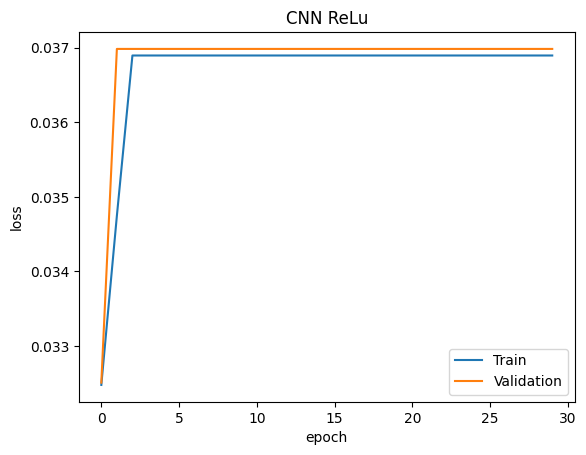

In [31]:
plt.plot(range(num_epochs), cnn_relu_train_losses)
plt.plot(range(num_epochs), cnn_relu_val_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("CNN ReLu")
plt.legend(["Train", "Validation"])


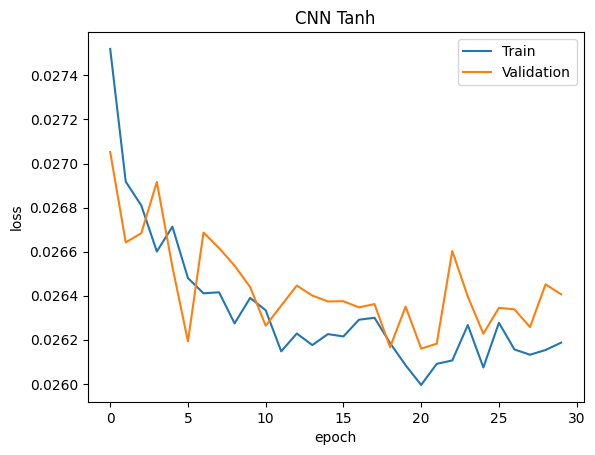

In [32]:
plt.plot(range(num_epochs), cnn_tanh_train_losses)
plt.plot(range(num_epochs), cnn_tanh_val_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("CNN Tanh")
plt.legend(["Train", "Validation"])


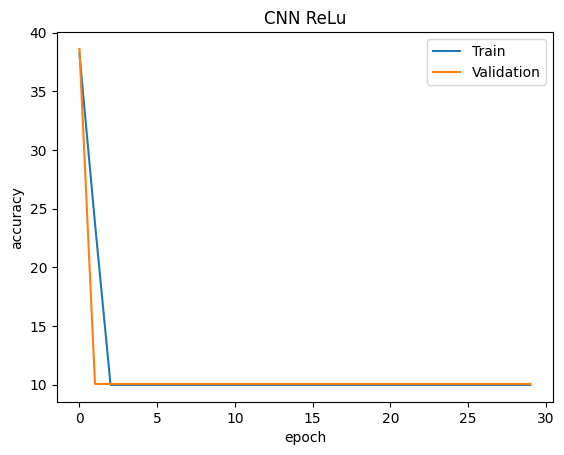

In [33]:
plt.plot(range(num_epochs), cnn_relu_train_accs)
plt.plot(range(num_epochs), cnn_relu_val_accs)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("CNN ReLu")
plt.legend(["Train", "Validation"])


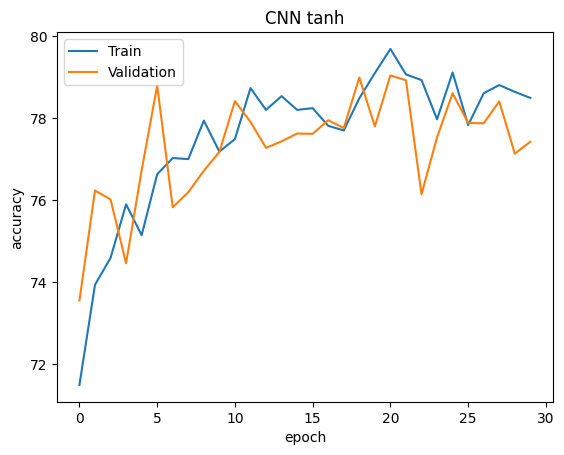

In [34]:
plt.plot(range(num_epochs), cnn_tanh_train_accs)
plt.plot(range(num_epochs), cnn_tanh_val_accs)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("CNN tanh")
plt.legend(["Train", "Validation"])

# How can we get to highr accuracy?

# First, define the max pooling and dropout techniques, and then use them in your model to enhance the accuracy.

#Report the accuracies and plot the mentioned figures.

In [36]:
class CNNReLUModel(nn.Module):

    def __init__(self):
        super(CNNReLUModel, self).__init__()

        self.conv1 = nn.Conv2d(1, 64, 3)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2, 1)
        self.conv2 = nn.Conv2d(64, 128, 3)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(2, 1)
        self.dropout1 = nn.Dropout(0.2)
        self.conv3 = nn.Conv2d(128, 64, 3)
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(2, 1)
        self.dropout2 = nn.Dropout(0.2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(19 * 19 * 64, 512)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(512, 256)
        self.relu5 = nn.ReLU()
        self.fc3 = nn.Linear(256, 128)
        self.relu6 = nn.ReLU()
        self.fc4 = nn.Linear(128, 64)
        self.relu7 = nn.ReLU()
        self.fc5 = nn.Linear(64, 10)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        x = self.dropout1(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.fc2(x)
        x = self.relu5(x)
        x = self.fc3(x)
        x = self.relu6(x)
        x = self.fc4(x)
        x = self.relu7(x)
        x = self.fc5(x)
        x = self.softmax(x)

        return x


In [37]:
class CNNTanhModel(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, 3),
            nn.Tanh(),
            nn.MaxPool2d(2, 1),
            nn.Conv2d(64, 128, 3),
            nn.Tanh(),
            nn.MaxPool2d(2, 1),
            nn.Dropout(0.2),
            nn.Conv2d(128, 64, 3),
            nn.Tanh(),
            nn.MaxPool2d(2, 1),
            nn.Dropout(0.2)
        )

        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(19 * 19 * 64, 512),
            nn.Tanh(),
            nn.Linear(512, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_relu_model = CNNReLUModel().to(device)
cnn_tanh_model = CNNTanhModel().to(device)
cnn_relu_optimizer = optim.Adam(cnn_relu_model.parameters(), lr = 0.001)
cnn_tanh_optimizer = optim.Adam(cnn_tanh_model.parameters(), lr = 0.001)

In [39]:
num_epochs = 30

cnn_train_losses, cnn_val_losses = {'relu': [], 'tanh': []}, {'relu': [], 'tanh': []}
cnn_train_accs, cnn_val_accs = {'relu': [], 'tanh': []}, {'relu': [], 'tanh': []}

for epoch in range(num_epochs):
    train_loss, train_acc = {'relu': 0, 'tanh': 0}, {'relu': 0, 'tanh': 0}

    for images, labels in tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{num_epochs}"):

        cnn_relu_model.train(True)
        cnn_tanh_model.train(True)

        images, labels = images.to(device), labels.to(device)

        cnn_relu_optimizer.zero_grad()
        cnn_tanh_optimizer.zero_grad()

        cnn_relu_outputs = cnn_relu_model(images)
        cnn_tanh_outputs = cnn_tanh_model(images)

        cnn_relu_loss = criterion(cnn_relu_outputs, labels)
        cnn_tanh_loss = criterion(cnn_tanh_outputs, labels)

        cnn_relu_loss.backward()
        cnn_tanh_loss.backward()

        cnn_relu_optimizer.step()
        cnn_tanh_optimizer.step()

        train_loss['relu'] += cnn_relu_loss.item()
        train_loss['tanh'] += cnn_tanh_loss.item()

        train_acc['relu'] += (torch.argmax(cnn_relu_outputs, dim=1) == labels).sum().item()
        train_acc['tanh'] += (torch.argmax(cnn_tanh_outputs, dim=1) == labels).sum().item()

    cnn_train_losses['relu'].append(train_loss['relu'] / len(train_data))
    cnn_train_losses['tanh'].append(train_loss['tanh'] / len(train_data))

    cnn_train_accs['relu'].append(train_acc['relu'] / len(train_data) * 100)
    cnn_train_accs['tanh'].append(train_acc['tanh'] / len(train_data) * 100)

    print(f"Epoch {epoch + 1}")
    print(f"cnn_relu_train_loss = {cnn_train_losses['relu'][-1]} cnn_relu_train_acc = {cnn_train_accs['relu'][-1]}")
    print(f"cnn_tanh_train_loss = {cnn_train_losses['tanh'][-1]} cnn_tanh_train_acc = {cnn_train_accs['tanh'][-1]}")

    with torch.no_grad():
        val_loss, val_acc = {'relu': 0, 'tanh': 0}, {'relu': 0, 'tanh': 0}

        for images, labels in val_dataloader:
            cnn_relu_model.train(False)
            cnn_tanh_model.train(False)

            images, labels = images.to(device), labels.to(device)

            cnn_relu_outputs = cnn_relu_model(images)
            cnn_tanh_outputs = cnn_tanh_model(images)

            cnn_relu_loss = criterion(cnn_relu_outputs, labels)
            cnn_tanh_loss = criterion(cnn_tanh_outputs, labels)

            val_loss['relu'] += cnn_relu_loss.item()
            val_loss['tanh'] += cnn_tanh_loss.item()

            val_acc['relu'] += (torch.argmax(cnn_relu_outputs, dim=1) == labels).sum().item()
            val_acc['tanh'] += (torch.argmax(cnn_tanh_outputs, dim=1) == labels).sum().item()

        cnn_val_losses['relu'].append(val_loss['relu'] / len(val_data))
        cnn_val_losses['tanh'].append(val_loss['tanh'] / len(val_data))

        cnn_val_accs['relu'].append(val_acc['relu'] / len(val_data) * 100)
        cnn_val_accs['tanh'].append(val_acc['tanh'] / len(val_data) * 100)

        print(f"cnn_relu_val_loss = {cnn_val_losses['relu'][-1]} cnn_relu_val_acc = {cnn_val_accs['relu'][-1]}")
        print(f"cnn_tanh_val_loss = {cnn_val_losses['tanh'][-1]} cnn_tanh_val_acc = {cnn_val_accs['tanh'][-1]}")



Epoch 1/30: 100%|██████████| 750/750 [00:34<00:00, 22.06it/s]


Epoch 1
cnn_relu_train_loss = 0.028173119549949964 cnn_relu_train_acc = 65.71666666666667
cnn_tanh_train_loss = 0.027641997394462426 cnn_tanh_train_acc = 70.63333333333334
cnn_relu_val_loss = 0.02936022561788559 cnn_relu_val_acc = 58.699999999999996
cnn_tanh_val_loss = 0.027002911458412805 cnn_tanh_val_acc = 73.61666666666666


Epoch 2/30: 100%|██████████| 750/750 [00:32<00:00, 23.06it/s]


Epoch 2
cnn_relu_train_loss = 0.02991409738113483 cnn_relu_train_acc = 54.6625
cnn_tanh_train_loss = 0.026944694891572 cnn_tanh_train_acc = 73.71666666666667
cnn_relu_val_loss = 0.029584956526756287 cnn_relu_val_acc = 57.291666666666664
cnn_tanh_val_loss = 0.02690487406651179 cnn_tanh_val_acc = 74.25833333333334


Epoch 3/30: 100%|██████████| 750/750 [00:31<00:00, 23.50it/s]


Epoch 3
cnn_relu_train_loss = 0.032628037196894485 cnn_relu_train_acc = 37.293749999999996
cnn_tanh_train_loss = 0.026911477078994116 cnn_tanh_train_acc = 73.84166666666667
cnn_relu_val_loss = 0.034920832494894666 cnn_relu_val_acc = 23.208333333333332
cnn_tanh_val_loss = 0.02713960870107015 cnn_tanh_val_acc = 72.675


Epoch 4/30: 100%|██████████| 750/750 [00:32<00:00, 23.14it/s]


Epoch 4
cnn_relu_train_loss = 0.034361671303709346 cnn_relu_train_acc = 26.200000000000003
cnn_tanh_train_loss = 0.026806900084018707 cnn_tanh_train_acc = 74.55000000000001
cnn_relu_val_loss = 0.03317761540412903 cnn_relu_val_acc = 34.35
cnn_tanh_val_loss = 0.027165953695774077 cnn_tanh_val_acc = 72.58333333333333


Epoch 5/30: 100%|██████████| 750/750 [00:32<00:00, 22.97it/s]


Epoch 5
cnn_relu_train_loss = 0.03606003129978975 cnn_relu_train_acc = 15.329166666666666
cnn_tanh_train_loss = 0.026811151780188083 cnn_tanh_train_acc = 74.38541666666667
cnn_relu_val_loss = 0.036995530525843305 cnn_relu_val_acc = 9.966666666666667
cnn_tanh_val_loss = 0.026531655063231786 cnn_tanh_val_acc = 76.48333333333333


Epoch 6/30: 100%|██████████| 750/750 [00:32<00:00, 23.30it/s]


Epoch 6
cnn_relu_train_loss = 0.03641310265660286 cnn_relu_train_acc = 13.070833333333335
cnn_tanh_train_loss = 0.02664587152500947 cnn_tanh_train_acc = 75.49583333333332
cnn_relu_val_loss = 0.036983811755975086 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.02683044215043386 cnn_tanh_val_acc = 74.78333333333333


Epoch 7/30: 100%|██████████| 750/750 [00:32<00:00, 22.76it/s]


Epoch 7
cnn_relu_train_loss = 0.03689395913481713 cnn_relu_train_acc = 9.99375
cnn_tanh_train_loss = 0.026626540427406628 cnn_tanh_train_acc = 75.63541666666667
cnn_relu_val_loss = 0.036983811755975086 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.02699339951078097 cnn_tanh_val_acc = 73.675


Epoch 8/30: 100%|██████████| 750/750 [00:34<00:00, 21.47it/s]


Epoch 8
cnn_relu_train_loss = 0.03689461014668147 cnn_relu_train_acc = 9.989583333333334
cnn_tanh_train_loss = 0.026663869127631187 cnn_tanh_train_acc = 75.43125
cnn_relu_val_loss = 0.036983811775843305 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.027080250243345896 cnn_tanh_val_acc = 73.21666666666667


Epoch 9/30: 100%|██████████| 750/750 [00:35<00:00, 21.32it/s]


Epoch 9
cnn_relu_train_loss = 0.03689395913481713 cnn_relu_train_acc = 9.99375
cnn_tanh_train_loss = 0.026643150232732296 cnn_tanh_train_acc = 75.4875
cnn_relu_val_loss = 0.036983811775843305 cnn_relu_val_acc = 10.066666666666666
cnn_tanh_val_loss = 0.02681209040681521 cnn_tanh_val_acc = 74.89166666666667


Epoch 10/30: 100%|██████████| 750/750 [00:34<00:00, 21.87it/s]


Epoch 10
cnn_relu_train_loss = 0.03689298257231712 cnn_relu_train_acc = 10.0
cnn_tanh_train_loss = 0.026360328167676927 cnn_tanh_train_acc = 77.31666666666666
cnn_relu_val_loss = 0.03698250969250997 cnn_relu_val_acc = 10.075000000000001
cnn_tanh_val_loss = 0.026349182158708573 cnn_tanh_val_acc = 77.775


Epoch 11/30: 100%|██████████| 750/750 [00:34<00:00, 21.87it/s]


Epoch 11
cnn_relu_train_loss = 0.03689265705148379 cnn_relu_train_acc = 10.002083333333333
cnn_tanh_train_loss = 0.02632334263622761 cnn_tanh_train_acc = 77.64166666666667
cnn_relu_val_loss = 0.03698250969250997 cnn_relu_val_acc = 10.075000000000001
cnn_tanh_val_loss = 0.026661162575085957 cnn_tanh_val_acc = 75.8


Epoch 12/30: 100%|██████████| 750/750 [00:34<00:00, 21.51it/s]


Epoch 12
cnn_relu_train_loss = 0.03689168048898379 cnn_relu_train_acc = 10.008333333333333
cnn_tanh_train_loss = 0.02658616546044747 cnn_tanh_train_acc = 75.90833333333333
cnn_relu_val_loss = 0.03698250969250997 cnn_relu_val_acc = 10.075000000000001
cnn_tanh_val_loss = 0.02672285077969233 cnn_tanh_val_acc = 75.375


Epoch 13/30: 100%|██████████| 750/750 [00:35<00:00, 20.95it/s]


Epoch 13
cnn_relu_train_loss = 0.03689265705148379 cnn_relu_train_acc = 10.002083333333333
cnn_tanh_train_loss = 0.026448147907853128 cnn_tanh_train_acc = 76.79166666666667
cnn_relu_val_loss = 0.03698250969250997 cnn_relu_val_acc = 10.075000000000001
cnn_tanh_val_loss = 0.026494540870189667 cnn_tanh_val_acc = 76.88333333333334


Epoch 14/30: 100%|██████████| 750/750 [00:36<00:00, 20.82it/s]


Epoch 14
cnn_relu_train_loss = 0.03689135496815046 cnn_relu_train_acc = 10.010416666666666
cnn_tanh_train_loss = 0.026362888117631277 cnn_tanh_train_acc = 77.30208333333334
cnn_relu_val_loss = 0.03698250969250997 cnn_relu_val_acc = 10.075000000000001
cnn_tanh_val_loss = 0.02640904940168063 cnn_tanh_val_acc = 77.46666666666667


Epoch 15/30: 100%|██████████| 750/750 [00:35<00:00, 21.12it/s]


Epoch 15
cnn_relu_train_loss = 0.03688549547890822 cnn_relu_train_acc = 10.047916666666666
cnn_tanh_train_loss = 0.026386629509429136 cnn_tanh_train_acc = 77.25
cnn_relu_val_loss = 0.036939540922641755 cnn_relu_val_acc = 10.35
cnn_tanh_val_loss = 0.026341698855161667 cnn_tanh_val_acc = 77.93333333333334


Epoch 16/30: 100%|██████████| 750/750 [00:34<00:00, 21.52it/s]


Epoch 16
cnn_relu_train_loss = 0.03687930618226528 cnn_relu_train_acc = 10.0875
cnn_tanh_train_loss = 0.02640340004613002 cnn_tanh_train_acc = 77.05833333333332
cnn_relu_val_loss = 0.037008551359176634 cnn_relu_val_acc = 9.891666666666667
cnn_tanh_val_loss = 0.026322735259930292 cnn_tanh_val_acc = 77.97500000000001


Epoch 17/30: 100%|██████████| 750/750 [00:35<00:00, 21.09it/s]


Epoch 17
cnn_relu_train_loss = 0.03688875080148379 cnn_relu_train_acc = 10.027083333333334
cnn_tanh_train_loss = 0.026313798815011977 cnn_tanh_train_acc = 77.62916666666668
cnn_relu_val_loss = 0.037008551359176634 cnn_relu_val_acc = 9.891666666666667
cnn_tanh_val_loss = 0.02670301706592242 cnn_tanh_val_acc = 75.52499999999999


Epoch 18/30: 100%|██████████| 750/750 [00:34<00:00, 21.51it/s]


Epoch 18
cnn_relu_train_loss = 0.03688875080148379 cnn_relu_train_acc = 10.027083333333334
cnn_tanh_train_loss = 0.026328068395455678 cnn_tanh_train_acc = 77.53125
cnn_relu_val_loss = 0.037008551359176634 cnn_relu_val_acc = 9.891666666666667
cnn_tanh_val_loss = 0.026662587960561118 cnn_tanh_val_acc = 75.88333333333334


Epoch 19/30: 100%|██████████| 750/750 [00:35<00:00, 21.37it/s]


Epoch 19
cnn_relu_train_loss = 0.03688875080148379 cnn_relu_train_acc = 10.027083333333334
cnn_tanh_train_loss = 0.026292280475298562 cnn_tanh_train_acc = 77.77708333333334
cnn_relu_val_loss = 0.037008551359176634 cnn_relu_val_acc = 9.891666666666667
cnn_tanh_val_loss = 0.02630081766843796 cnn_tanh_val_acc = 78.125


Epoch 20/30: 100%|██████████| 750/750 [00:35<00:00, 21.24it/s]


Epoch 20
cnn_relu_train_loss = 0.03688875080148379 cnn_relu_train_acc = 10.027083333333334
cnn_tanh_train_loss = 0.026289653949439527 cnn_tanh_train_acc = 77.80833333333334
cnn_relu_val_loss = 0.037008551359176634 cnn_relu_val_acc = 9.891666666666667
cnn_tanh_val_loss = 0.026646444668372474 cnn_tanh_val_acc = 75.94166666666666


Epoch 21/30: 100%|██████████| 750/750 [00:35<00:00, 21.35it/s]


Epoch 21
cnn_relu_train_loss = 0.03688875080148379 cnn_relu_train_acc = 10.027083333333334
cnn_tanh_train_loss = 0.026099414659043155 cnn_tanh_train_acc = 78.97916666666667
cnn_relu_val_loss = 0.037008551359176634 cnn_relu_val_acc = 9.891666666666667
cnn_tanh_val_loss = 0.02588431806365649 cnn_tanh_val_acc = 80.65833333333333


Epoch 22/30: 100%|██████████| 750/750 [00:35<00:00, 21.36it/s]


Epoch 22
cnn_relu_train_loss = 0.03688875080148379 cnn_relu_train_acc = 10.027083333333334
cnn_tanh_train_loss = 0.026217506639659403 cnn_tanh_train_acc = 78.23541666666667
cnn_relu_val_loss = 0.037008551359176634 cnn_relu_val_acc = 9.891666666666667
cnn_tanh_val_loss = 0.026116992125908532 cnn_tanh_val_acc = 79.3


Epoch 23/30: 100%|██████████| 750/750 [00:34<00:00, 21.55it/s]


Epoch 23
cnn_relu_train_loss = 0.03688875080148379 cnn_relu_train_acc = 10.027083333333334
cnn_tanh_train_loss = 0.025926321856677533 cnn_tanh_train_acc = 80.12708333333333
cnn_relu_val_loss = 0.037008551359176634 cnn_relu_val_acc = 9.891666666666667
cnn_tanh_val_loss = 0.026289411852757134 cnn_tanh_val_acc = 78.225


Epoch 24/30: 100%|██████████| 750/750 [00:34<00:00, 21.56it/s]


Epoch 24
cnn_relu_train_loss = 0.03688875080148379 cnn_relu_train_acc = 10.027083333333334
cnn_tanh_train_loss = 0.025931998727222284 cnn_tanh_train_acc = 80.09583333333333
cnn_relu_val_loss = 0.037008551359176634 cnn_relu_val_acc = 9.891666666666667
cnn_tanh_val_loss = 0.026191154927015306 cnn_tanh_val_acc = 78.81666666666666


Epoch 25/30: 100%|██████████| 750/750 [00:34<00:00, 21.52it/s]


Epoch 25
cnn_relu_train_loss = 0.03688875080148379 cnn_relu_train_acc = 10.027083333333334
cnn_tanh_train_loss = 0.026014800429344176 cnn_tanh_train_acc = 79.53125
cnn_relu_val_loss = 0.037008551359176634 cnn_relu_val_acc = 9.891666666666667
cnn_tanh_val_loss = 0.026197344839572905 cnn_tanh_val_acc = 78.825


Epoch 26/30: 100%|██████████| 750/750 [00:34<00:00, 21.56it/s]


Epoch 26
cnn_relu_train_loss = 0.03688875080148379 cnn_relu_train_acc = 10.027083333333334
cnn_tanh_train_loss = 0.026015238175789514 cnn_tanh_train_acc = 79.51458333333333
cnn_relu_val_loss = 0.037008551359176634 cnn_relu_val_acc = 9.891666666666667
cnn_tanh_val_loss = 0.025906150499979654 cnn_tanh_val_acc = 80.74166666666667


Epoch 27/30: 100%|██████████| 750/750 [00:34<00:00, 21.81it/s]


Epoch 27
cnn_relu_train_loss = 0.03688875080148379 cnn_relu_train_acc = 10.027083333333334
cnn_tanh_train_loss = 0.025998872476319473 cnn_tanh_train_acc = 79.67291666666667
cnn_relu_val_loss = 0.037008551359176634 cnn_relu_val_acc = 9.891666666666667
cnn_tanh_val_loss = 0.02627414979537328 cnn_tanh_val_acc = 78.225


Epoch 28/30: 100%|██████████| 750/750 [00:34<00:00, 21.56it/s]


Epoch 28
cnn_relu_train_loss = 0.03688875080148379 cnn_relu_train_acc = 10.027083333333334
cnn_tanh_train_loss = 0.025942453314860663 cnn_tanh_train_acc = 80.02916666666667
cnn_relu_val_loss = 0.037008551359176634 cnn_relu_val_acc = 9.891666666666667
cnn_tanh_val_loss = 0.026254261076450347 cnn_tanh_val_acc = 78.38333333333334


Epoch 29/30: 100%|██████████| 750/750 [00:34<00:00, 21.69it/s]


Epoch 29
cnn_relu_train_loss = 0.03688875080148379 cnn_relu_train_acc = 10.027083333333334
cnn_tanh_train_loss = 0.025974270661671957 cnn_tanh_train_acc = 79.76875
cnn_relu_val_loss = 0.037008551359176634 cnn_relu_val_acc = 9.891666666666667
cnn_tanh_val_loss = 0.026350219428539275 cnn_tanh_val_acc = 77.71666666666667


Epoch 30/30: 100%|██████████| 750/750 [00:34<00:00, 21.43it/s]


Epoch 30
cnn_relu_train_loss = 0.03688875080148379 cnn_relu_train_acc = 10.027083333333334
cnn_tanh_train_loss = 0.026004659081498783 cnn_tanh_train_acc = 79.68333333333332
cnn_relu_val_loss = 0.037008551359176634 cnn_relu_val_acc = 9.891666666666667
cnn_tanh_val_loss = 0.02672326965133349 cnn_tanh_val_acc = 75.59166666666667


In [40]:
test_loss, test_acc = {'relu': 0, 'tanh': 0}, {'relu': 0, 'tanh': 0}

with torch.no_grad():
    for images, labels in test_dataloader:
        cnn_relu_model.eval()
        cnn_tanh_model.eval()

        images, labels = images.to(device), labels.to(device)

        cnn_relu_outputs = cnn_relu_model(images)
        cnn_tanh_outputs = cnn_tanh_model(images)

        cnn_relu_loss = criterion(cnn_relu_outputs, labels)
        cnn_tanh_loss = criterion(cnn_tanh_outputs, labels)

        test_loss['relu'] += cnn_relu_loss.item()
        test_loss['tanh'] += cnn_tanh_loss.item()

        test_acc['relu'] += (torch.argmax(cnn_relu_outputs, dim=1) == labels).sum().item()
        test_acc['tanh'] += (torch.argmax(cnn_tanh_outputs, dim=1) == labels).sum().item()

    print(f"cnn_relu_test_loss = {test_loss['relu'] / len(test_data)} cnn_relu_test_acc = {test_acc['relu'] / len(test_data) * 100}")
    print(f"cnn_tanh_test_loss = {test_loss['tanh'] / len(test_data)} cnn_tanh_test_acc = {test_acc['tanh'] / len(test_data) * 100}")


cnn_relu_test_loss = 0.03706350636482239 cnn_relu_test_acc = 10.0
cnn_tanh_test_loss = 0.026796252286434175 cnn_tanh_test_acc = 75.38


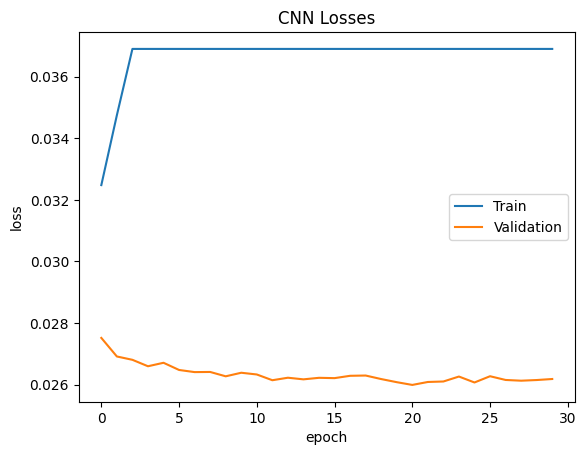

In [41]:
for model_name, losses in {'relu': cnn_relu_train_losses, 'tanh': cnn_tanh_train_losses}.items():
    plt.plot(range(num_epochs), losses)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("CNN Losses")

plt.legend(["Train", "Validation"])


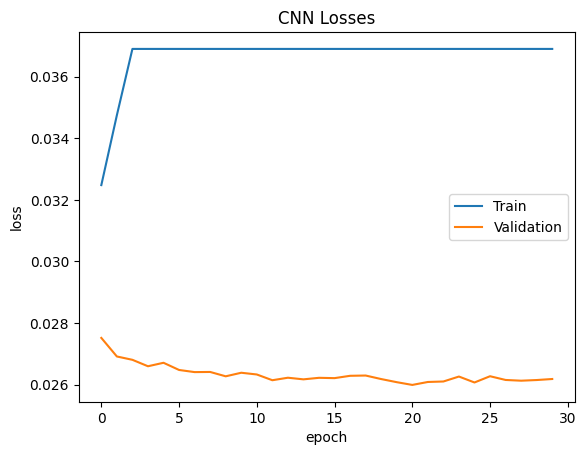

In [42]:
for model_name, losses in {'relu': cnn_relu_train_losses, 'tanh': cnn_tanh_train_losses}.items():
    plt.plot(range(num_epochs), losses)

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("CNN Losses")

plt.legend(["Train", "Validation"])


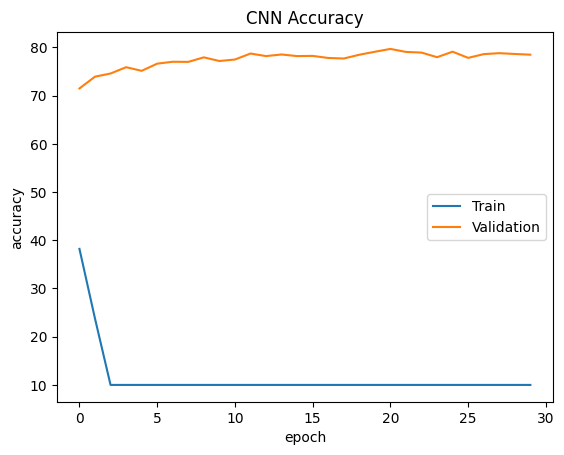

In [43]:
for model_name, accs in {'relu': cnn_relu_train_accs, 'tanh': cnn_tanh_train_accs}.items():
    plt.plot(range(num_epochs), accs)

plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("CNN Accuracy")

plt.legend(["Train", "Validation"])


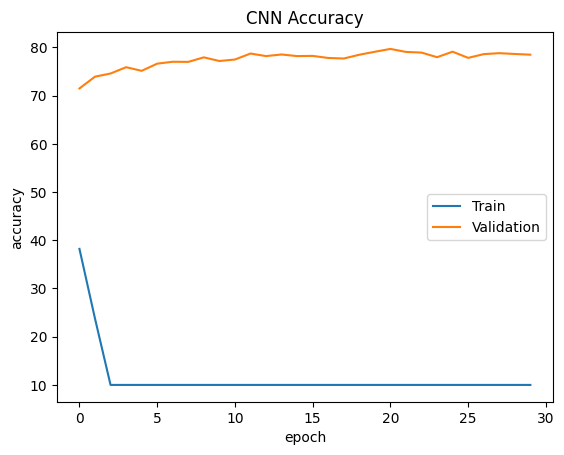

In [44]:
for model_name, accs in {'relu': cnn_relu_train_accs, 'tanh': cnn_tanh_train_accs}.items():
    plt.plot(range(num_epochs), accs)

plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.title("CNN Accuracy")

plt.legend(["Train", "Validation"])
